In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 150
import glob, os

import scipy.stats as st
import timeit
from sklearn.decomposition import PCA

import iqplot
import bokeh.io
import bokeh.plotting

from bokeh.io import export_png, export_svgs

bokeh.io.output_notebook()

from statsmodels.miscmodels.ordinal_model import OrderedModel

Loading BokehJS ...

# Regress viral severity on predictors

(severity) ~ (# of human targets) + (# of papers studying the virus) + (size of viral genomes)

In [2]:
# also rearranged so that all Homo sapiens is in the right column
virus_human = pd.read_csv("../Processed/virus_human.csv")

In [ ]:
# check that all human proteins are in the second column
print(virus_human['Taxname B'].unique(), virus_human['Taxid B'].unique())

# human should not be in the first column
print('Homo sapiens' in virus_human['Taxname A'].values)
print(9606 in virus_human['Taxid A'].values)

In [ ]:
print(len(virus_human["Taxname A"].unique()), "viral species in the PPI dataset")

In [ ]:
print(len(virus_human["Taxid A"].unique()), "viral taxa in the PPI dataset")

In [ ]:
# save taxids to a text file to search with Taxonomizr in R (code below)
virus_human[["Taxid A"]].drop_duplicates().to_csv("viral_taxids.txt", index=False, sep="\t")

# Get taxonomic ranks using `Taxonomizr` in R

## Easiest way to collapse groups of viruses (i.e. different papillomaviruses will also have the same genus)

https://cran.r-project.org/web/packages/taxonomizr/vignettes/usage.html

```r
install.packages("taxonomizr")
library(taxonomizr)

prepareDatabase('accessionTaxa.sql')

df <- read.table("viral_taxids.txt", stringsAsFactors=FALSE, quote="", header=TRUE, sep="\t")

taxids <- df[["Taxid.A"]]

# get taxonomies for the taxids
taxa <- getTaxonomy(taxids,'accessionTaxa.sql')

# save taxa to a new dataframe
write.csv(taxa, "viral_taxonomies.csv")
```

In [ ]:
# viral_taxonomies = pd.read_csv("viral_taxonomies.csv")
# viral_taxonomies.rename(columns={viral_taxonomies.columns[0]: 'Taxid A'}, inplace=True)

# # combine the taxonomies with the original dataframe
# virus_human = pd.merge(virus_human, viral_taxonomies, on='Taxid A')
# virus_human.to_csv("../Processed/virus_human.csv", index=False)

# # check that there are no NaNs
# for col in virus_human.columns:
#     assert sum(pd.isnull(virus_human[col])) == 0

# Get genome sizes of all the viruses

https://www.ncbi.nlm.nih.gov/genome/browse/#!/viruses/

Use taxonomizr to get the exact species name, rather than the strain name (which is what's associated with the taxids).

This species name should be easier to search than the taxid-associated taxname.

In [3]:
virus_genome_sizes = pd.read_csv("../Data/virus_genome_sizes.csv")

In [4]:
# ~1/2 as many species as taxids
print(len(virus_human.species.unique()))

# make a dictionary to map between them
taxnames_species_dict = dict(zip(virus_human["Taxname A"], virus_human["species"]))

91


In [5]:
# this only has 62 of the 83 species in the dataframe. Compare families for the rest because the Organism Groups column contains them
found_viruses_df = virus_genome_sizes.loc[virus_genome_sizes["#Organism Name"].isin(virus_human['species'].unique())].drop_duplicates(["#Organism Name", "Size(Mb)"])

found_viruses = found_viruses_df["#Organism Name"].unique()

print(len(found_viruses), "viruses found in the database")

missing_viruses = list(set(virus_human['species'].unique()) - set(found_viruses))

print(len(missing_viruses), "viruses not a direct match")

66 viruses found in the database
25 viruses not a direct match


In [6]:
virus_genomes_df = pd.DataFrame(found_viruses_df.groupby("#Organism Name")["Size(Mb)"].mean()).reset_index()
virus_genomes_df.columns = ["Species", "Size(Mb)"]

add_viruses_to_df = []
genome_sizes = []

for virus in missing_viruses:
    
    search_term = virus.split(" ")
    
    # sometimes the split results in the last word being "virus"
    if "virus" in search_term:
        search_term.remove("virus")
    
    # don't search the last term if it is of length 1 or 2, which means that it's a strain number
    # this confounds the results by including searches for A or 10 or something like that
    if len(search_term[-1]) in [1, 2]:  
        search_term = search_term[:-1]
        
    res_df = virus_genome_sizes.loc[virus_genome_sizes["#Organism Name"].str.contains("|".join(search_term), case=False)]
    if len(res_df) > 0:
        genome_sizes.append(res_df["Size(Mb)"].mean())
        add_viruses_to_df.append(virus)
    else:
        print(virus)
        
# add rubella virus manually because it's just 1 virus
add_viruses_to_df.append("Rubivirus rubellae")
genome_sizes.append(virus_genome_sizes.loc[virus_genome_sizes["#Organism Name"].str.contains("rubella", case=False)]["Size(Mb)"].mean())

virus_genomes_df = pd.concat([virus_genomes_df, pd.DataFrame({"Species": add_viruses_to_df, "Size(Mb)": genome_sizes})]).reset_index(drop=True)

assert len(set(virus_genomes_df["Species"]).intersection(virus_human["species"])) == len(virus_genomes_df)

Rubivirus rubellae


In [7]:
model_df = pd.DataFrame(taxnames_species_dict, index=[0]).T.reset_index()
model_df.columns = ["Taxname", "Species"]

# combine with the genome lengths
model_df = pd.merge(model_df, virus_genomes_df, on="Species", how="outer")

# number of proteins interacting with human proteins for a given viral species
protein_interactions = pd.DataFrame(virus_human.groupby(["Taxname A"])["Protein B"].apply(lambda x: len(np.unique(x)))).reset_index()
protein_interactions.columns = ["Taxname", "num_unique_interactions"]

# combine with the protein_interactions list
model_df = pd.merge(model_df, protein_interactions, on="Taxname", how="outer")

publications_df = pd.DataFrame(virus_human.groupby(["Taxname A"])["Publication"].apply(lambda x: len(np.unique(x)))).reset_index()
publications_df.columns = ["Taxname", "num_publications"]

# combine with the publications list
model_df = pd.merge(model_df, publications_df, on="Taxname", how="outer")

# add the taxids for easy cross-referencing
model_df = pd.merge(virus_human[["Taxid A", "Taxname A"]].drop_duplicates(), model_df, left_on="Taxname A", right_on="Taxname", how="inner")

# duplicate column now
del model_df["Taxname A"]

model_df.rename(columns={"Taxid A": "Taxid"}, inplace=True)

# convert megabase size to kilobase to be on the same scale as the other variables
model_df["Size(Mb)"] *= 1000
model_df.rename(columns={"Size(Mb)":"Size(Kb)"}, inplace=True)

# finally, save it to a dataframe for modeling later (need the outcome variable)
#model_df.to_csv("model_predictors.csv", index=False)

### Manually determined which viruses predominantly infect animals and removed them

For studying protein-protein interactions, these are useful, but for the viral severity model, the outcome variable is severity in humans. Therefore, it makes sense to consider only viruses that infect humans with clinical relevance. 

In [8]:
nonhuman_viruses = ['Avian infectious bronchitis virus (strain Beaudette US)', 'Avian infectious bronchitis virus (strain Beaudette)', 'Avian sarcoma virus PR2257', 'Macaca mulatta polyomavirus 1',
                   "Marek's disease herpesvirus type 1 strain MD5", 'Pipistrellus bat coronavirus HKU5', 'Rousettus bat coronavirus HKU9',
                    'Canine enteric coronavirus INSAVC-1','Porcine transmissible gastroenteritis coronavirus strain Purdue',
                    'Porcine respiratory coronavirus (STRAIN RM4)', 'Bat SARS CoV Rp3/2004', 'Murine hepatitis virus strain A59', 
                    'Bovine coronavirus strain Quebec', 'Semliki Forest virus', 'Suid alphaherpesvirus 1', 
                    'Equine herpesvirus type 1 (strain Kentucky A)', 'Equid alphaherpesvirus 1', 'Equid herpesvirus type 2 strain 86/87',
                   'Bos taurus papillomavirus 2', 'Murine adenovirus 1', 'Fowl aviadenovirus 1', 'Hog cholera virus (strain Alfort)',
                   'Bovine herpesvirus type 1.1', 'Bovine gammaherpesvirus 4', 'Bovine herpesvirus type 1.1 (strain Cooper)',
                   'Bat coronavirus BM48-31/BGR/2008', 'Mus musculus polyomavirus 1', 'Rous sarcoma virus (strain Schmidt-Ruppin A)',
                   'Murid gammaherpesvirus 4', 'Bovine alphaherpesvirus 1','Bat coronavirus RaTG13', 'Pangolin coronavirus', 'Simian virus 5 (strain W3)',
                    'Bovine herpesvirus type 1.1 (strain Jura)', 'Classical swine fever virus - Alfort/187', 'Classical swine fever virus - Brescia',
                    'Bat SARS-like coronavirus WIV1', 'Encephalomyocarditis virus', 'SARS coronavirus HB','Porcine enteric alphacoronavirus','Murine cytomegalovirus (strain Smith)',
                   'Bovine viral diarrhea virus 1-NADL', 'African swine fever virus', 'Murine polyomavirus strain A3',
                   'Herpesvirus saimiri (strain 488)', 'Herpesvirus saimiri (strain 11)', 'Murine minute virus strain MVM prototype',
                   'Simian immunodeficiency virus (PBJ/BC13 ISOLATE) (SOOTY MANGABEY)', 'Simian immunodeficiency virus']

model_df_human = model_df.loc[~model_df["Taxname"].isin(nonhuman_viruses)]
model_df_human.to_csv("model_predictors_human.csv", index=False)

# Start here if all files have already been generated

In [2]:
model_df = pd.read_csv("model_predictors.csv")
model_df_human = pd.read_csv("model_predictors_human.csv")

model_df_human

,Taxid,Taxname,Species,Size(Kb),num_unique_interactions,num_publications
0,1263720,Betacoronavirus England 1,Middle East respiratory syndrome-related coron...,30.119000,573,23
1,694009,Severe acute respiratory syndrome-related coro...,Severe acute respiratory syndrome-related coro...,29.274000,1155,77
2,11295,Rabies virus ERA,Rabies lyssavirus,11.916765,3651,2
3,11137,Human coronavirus 229E,Human coronavirus 229E,27.317000,386,5
4,1235996,Human betacoronavirus 2c EMC/2012,Middle East respiratory syndrome-related coron...,30.119000,8,4
...,...,...,...,...,...,...
135,31635,Dengue virus 2 16681-PDK53,Dengue virus,10.693167,106,1
136,648242,Adeno-associated virus 2 Srivastava/1982,Adeno-associated dependoparvovirus A,4.575765,1,1
137,10360,Human herpesvirus 5 strain AD169,Human betaherpesvirus 5,234.511500,3,1
138,11113,Hepatitis C virus isolate HC-J6,Hepacivirus C,9.432274,1,1


In [3]:
len(model_df_human.Taxname.unique()), len(model_df_human.Species.unique())

(140, 60)

In [4]:
viral_severity = []

for virus in model_df_human.Taxname.values:
    
    if any(map(virus.lower().__contains__, ["229e", "nl63", "oc43", "hku1", "vesicul", "vaccinia", "syncytial", "orthopneumovirus"])):
        viral_severity.append("very low")
        
    # betaherpesviruses include CMV, HepE (Orthohepe), HHV-5 = CMV
    elif any(map(virus.lower().__contains__, ["adeno", "parvo", "hepe", "h1n1", "h3n2", "alphaherpesvirus", "lymphotrophic", "polyomavirus", "zika",
                                             "rubella", "measles", "herpesvirus 6", "herpesvirus 2", "herpesvirus 5"])):
        viral_severity.append("low")
        
    # HHV-4 = EBV, HHV-8 = KSHV. Kunjin virus is a subtype of West Nile
    elif any(map(virus.lower().__contains__, ["polio", "hepa", "hiv", "enterovirus a71", "dengue", "nile", "h5n1", "h7n7", "h9n2", "immunodeficiency", "papillomavirus", "sars", "betacoronavirus",
                                             "severe acute respiratory syndrome", "encephalitis", "coronavirus 2", "epstein", "leukemia", "lymphotropic", "lymphocytic", "herpesvirus 4", "herpesvirus 8", "kunjin"])):
        viral_severity.append("moderate")
        
    elif any(map(virus.lower().__contains__, ["rabies", "henipa", "ebola", "middle east", "hemorrhagic", "phlebo", "sfts"])):
        viral_severity.append("severe")
        
    else:
        print(virus)
        
model_df_human["Severity"] = pd.Categorical(viral_severity, categories=["very low", "low", "moderate", "severe"], ordered=True)

In [5]:
def spearman_rho_corr(df, col1, col2):
    
    sns.scatterplot(data=df, x=col1, y=col2)
    plt.xscale("log")
    plt.yscale("log")
    sns.despine()
    plt.show()
    
    return st.spearmanr(df[col1], df[col2])

In [6]:
def make_export_strip_plot(df, plot_variable, output_file, ylabel=None):
    
    p = iqplot.stripbox(data=df, cats=["Severity"], q=plot_variable, q_axis="y", 
                    y_axis_type="log", jitter=True, height=550, width=800,
                        marker_kwargs={"size":6, "alpha":1},
                       #y_axis_label=ylabel
                       )
    
    p.xaxis.major_label_text_font_size = '16pt'
    p.yaxis.major_label_text_font_size = '16pt'
    bokeh.io.show(p)

    p.output_backend = "svg"
    
    if ".svg" not in output_file:
        output_file += ".svg"
    
    export_svgs(p, filename=output_file)

In [7]:
from selenium import webdriver
import chromedriver_binary  # Adds chromedriver binary to path

# driver = webdriver.Chrome()
# driver.get("http://www.python.org")
# assert "Python" in driver.title

In [8]:
make_export_strip_plot(model_df_human, "num_unique_interactions", "../Figures/interactions_stripbox.svg", "Interactions")

In [9]:
make_export_strip_plot(model_df_human, "num_publications", "../Figures/publications_stripbox.svg", "Publications")

In [10]:
make_export_strip_plot(model_df_human, "Size(Kb)", "../Figures/genome_stripbox.svg", "Genome Size (kb)")

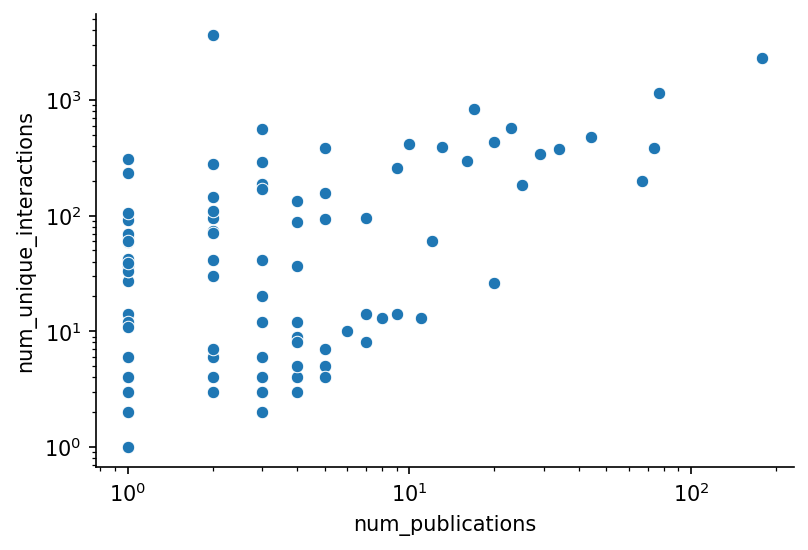

SpearmanrResult(correlation=0.6163184072183158, pvalue=5.234022980731022e-16)

In [11]:
# might be the biggest predictor. Spearman rho totally not significant for num_interactions and genome size
spearman_rho_corr(model_df_human, "num_publications", "num_unique_interactions")

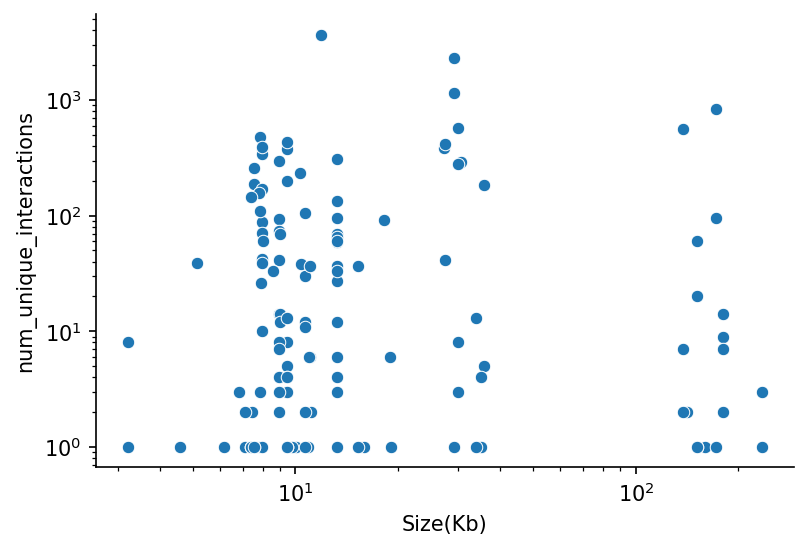

SpearmanrResult(correlation=0.07580908164030033, pvalue=0.3733449876134395)

In [12]:
spearman_rho_corr(model_df_human, "Size(Kb)", "num_unique_interactions")

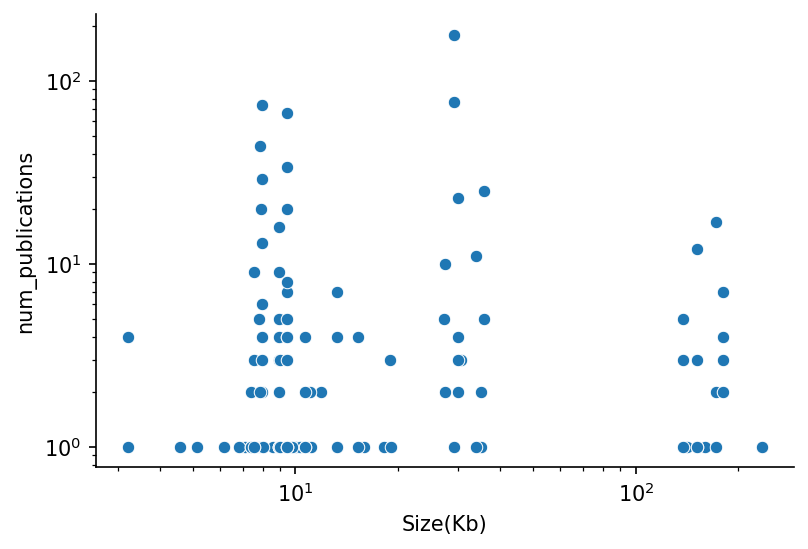

SpearmanrResult(correlation=0.09515413623721056, pvalue=0.263428423236626)

In [13]:
spearman_rho_corr(model_df_human, "Size(Kb)", "num_publications")

# Logit Ordinal Regression

In [14]:
mod_prob = OrderedModel(model_df_human['Severity'],
                        model_df_human[['Size(Kb)', 'num_unique_interactions', 'num_publications']],
                        distr='logit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.886458
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:               Severity   Log-Likelihood:                -124.10
Model:                   OrderedModel   AIC:                             260.2
Method:            Maximum Likelihood   BIC:                             277.9
Date:                Thu, 12 May 2022                                         
Time:                        10:15:53                                         
No. Observations:                 140                                         
Df Residuals:                     134                                         
Df Model:                           6                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Size(Kb)                   -0.0134      0.003     -4.290      0.000      -0.019      -0.007
num_unique_interactions     0.0013      0.001      1.831      0.067   -9.16e-05       0.003
num_publications           -0.0069      0.012     -0.557      0.577      -0.031       0.017
very low/low               -3.1349      0.399     -7.860      0.000      -3.917      -2.353
low/moderate                0.6052      0.179      3.381      0.001       0.254       0.956
moderate/severe             1.3954      0.104     13.423      0.000       1.192       1.599
===========================================================================================
"""

In [15]:
pd.DataFrame(model_df_human.groupby("Species")["num_unique_interactions"].sum()).sort_values("num_unique_interactions", ascending=False).iloc[:5, :]

,num_unique_interactions
Species,
Rabies lyssavirus,3651
Severe acute respiratory syndrome-related coronavirus,3452
Hepacivirus C,1057
Human gammaherpesvirus 4,933
Influenza A virus,916


In [16]:
pd.DataFrame(model_df_human.groupby("Species")["num_unique_interactions"].sum()).query("num_unique_interactions==1")

,num_unique_interactions
Species,
Adeno-associated dependoparvovirus A,1
Betapapillomavirus 4,1
Betapapillomavirus 5,1
Crimean-Congo hemorrhagic fever orthonairovirus,1
Enterovirus A,1
Gammapapillomavirus 1,1
Human betaherpesvirus 6A,1
Human immunodeficiency virus 2,1
Human mastadenovirus D,1
